<a href="https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
os.chdir("/home/mgjeong/Desktop/etri_hd/yolov5")

In [4]:
%cd ../yolov5
from yolov5 import utils
display = utils.notebook_init()  # checks

/home/mgjeong/Desktop/etri_hd/datasets


ModuleNotFoundError: No module named 'yolov5'

In [5]:
%pip install -qr ../yolov5/requirements.txt  # install

Note: you may need to restart the kernel to use updated packages.


# Setup

Clone repo, install dependencies and check PyTorch and GPU.

# 1. Inference

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          path/  # directory
                          path/*.jpg  # glob
                          'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                          'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

In [3]:
#conda install matplotlib
!python detect.py --weights ./weights/vis_l_100.pt --img 640 --conf 0.25 --source data/test

detect: weights=['./weights/vis_l_100.pt'], source=data/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
/home/mgjeong/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.11.0+c

detect: weights=['weights/yolov5l.pt'], source=../datasets/220520_test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
/home/mgjeong/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
YOLOv5 🚀 2022-4-25 torch 1.11.

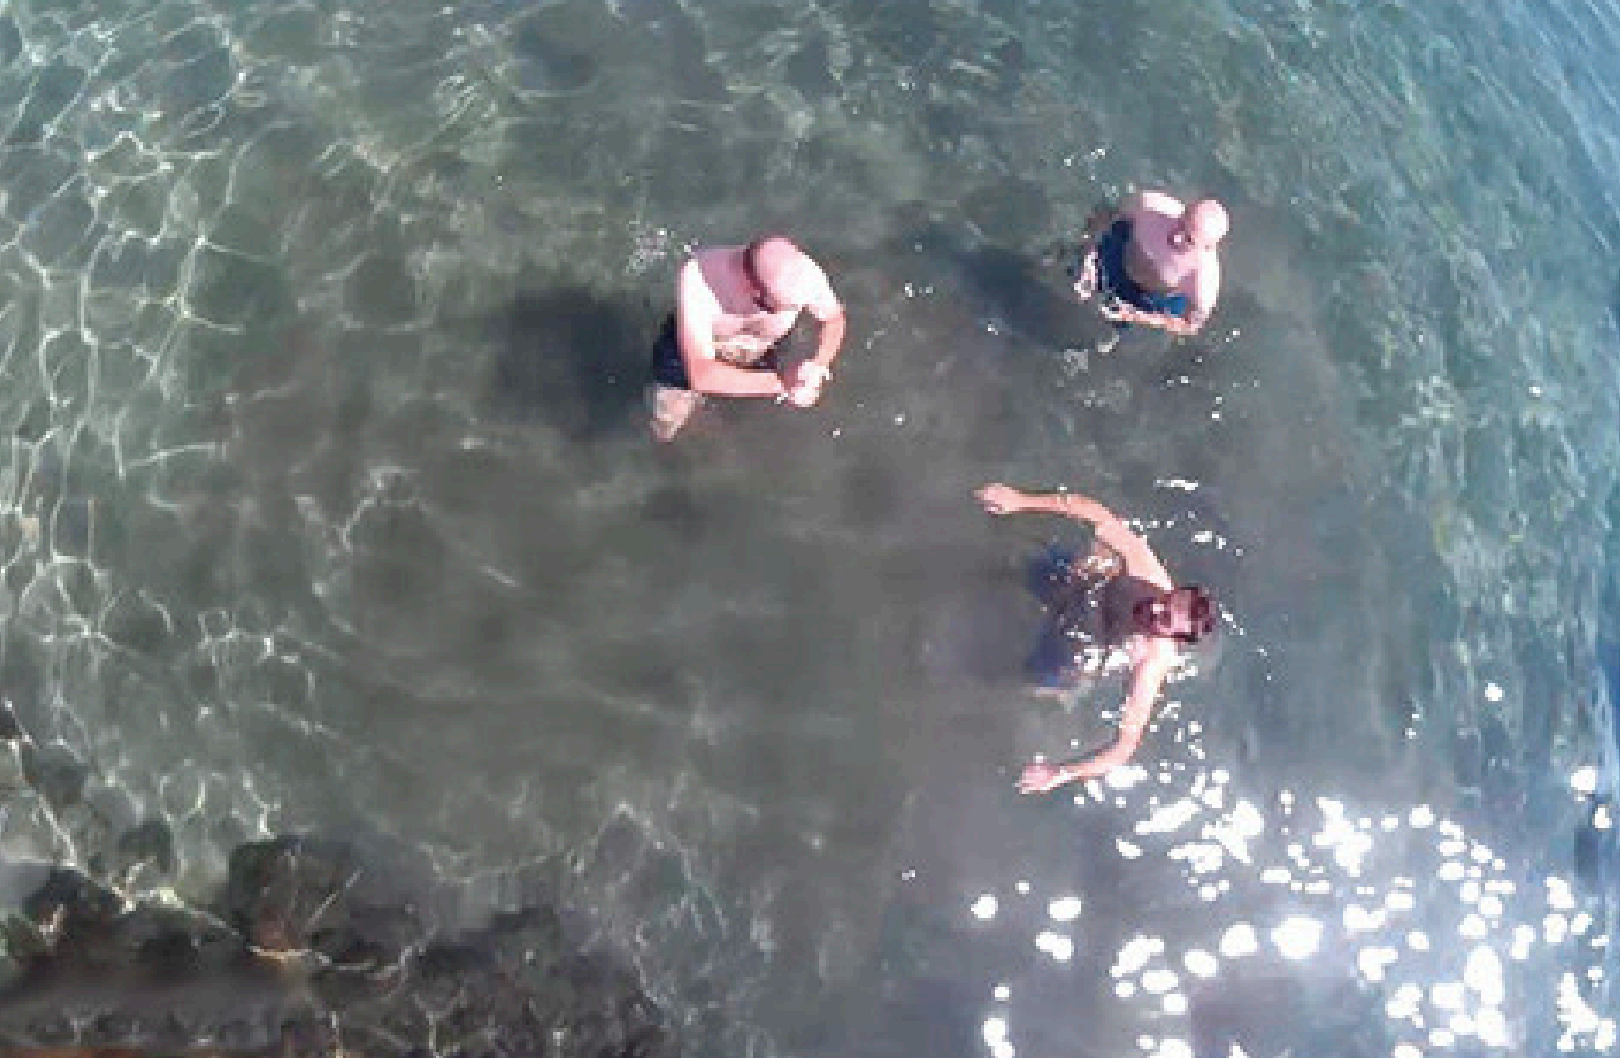

In [11]:
import IPython.display as display
from PIL import Image
!python detect.py --weights weights/yolov5l.pt --img 640 --conf 0.25 --source ../datasets/220520_test/
display.Image(filename='../datasets/220520_test/swim_001.png', width=600)

#display.display(Image.open('../datasets/220520_test/1.jpeg', width=600))


## Download Visdrone by quoting yaml code

In [12]:
#input file
fin = open("data.txt", "rt")
#output file to write the result to
fout = open("out.txt", "wt")
#for each line in the input file
for line in fin:
    #read replace the string and write to output file
    fout.write(line.replace('pyton', 'python'))
#close input and output files
fin.close()
fout.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data.txt'

## 1. First, Visdrone labels format convert to yolo labels format

In [14]:
from utils.general import download, os, Path

In [15]:
def visdrone2yolo(dir):
    from PIL import Image
    from tqdm.auto import tqdm

    def convert_box(size, box):
      # Convert VisDrone box to YOLO xywh box
        dw = 1. / size[0]
        dh = 1. / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

    (dir / 'labels').mkdir(parents=True, exist_ok=True)  # make labels directory
    pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
    for f in pbar:
        img_size = Image.open((dir / 'images' / f.name).with_suffix('.jpg')).size
        lines = []
        with open(f, 'r') as file:  # read annotation.txt
            for row in [x.split(',') for x in file.read().strip().splitlines()]:
                if row[4] == '0':  # VisDrone 'ignored regions' class 0
                    continue
                cls = int(row[5]) - 1
                box = convert_box(img_size, tuple(map(int, row[:4])))
                lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
                with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                    fl.writelines(lines)  # write label.txt



## 2. Check yolo labels format is correct

### detect.py (149~172 lines) :


### Process predictions
def detect_show_images(pred):

    for i, det in enumerate(pred):  # per image

        seen += 1
        if webcam:  # batch_size >= 1
            p, im0, frame = path[i], im0s[i].copy(), dataset.count
            s += f'{i}: '
        else:
            p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

        p = Path(p)  # to Path
        save_path = str(save_dir / p.name)  # im.jpg
        txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
        s += '%gx%g ' % im.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        imc = im0.copy() if save_crop else im0  # for save_crop
        annotator = Annotator(im0, line_width=line_thickness, example=str(names))
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                if save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')

                if save_img or save_crop or view_img:  # Add bbox to image
                    c = int(cls)  # integer class
                    label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                    annotator.box_label(xyxy, label, color=colors(c, True))
                    if save_crop:
                        save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

        # Stream results
        im0 = annotator.result()
        if view_img:
            cv2.imshow(str(p), im0)
            cv2.waitKey(1)  # 1 millisecond

        # Save results (image with detections)
        if save_img:
            if dataset.mode == 'image':
                cv2.imwrite(save_path, im0)
            else:  # 'video' or 'stream'
                if vid_path[i] != save_path:  # new video
                    vid_path[i] = save_path
                    if isinstance(vid_writer[i], cv2.VideoWriter):
                        vid_writer[i].release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]
                    save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                    vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer[i].write(im0)


In [16]:
from utils.plots import Annotator, colors, save_one_box
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)

In [17]:
from PIL import Image, ImageDraw

In [66]:
#https://beok.tistory.com/46
#https://dacon.io/codeshare/1696

#file = '../datasets/VisDrone_Reduction/images/test/9999938_00000_d_0000215.jpg'
#file_label = '../datasets/VisDrone_Reduction/labels/test/9999938_00000_d_0000215.txt'
file = '../datasets/coco_reduction/images/val/000000118405.jpg'
file_label = '../datasets/coco_reduction/labels/val/000000118405.txt'

img = Image.open(file).convert('RGB')
width = 1
color = (0,255,0)

f = open(file_label) # Open file on read mode
lines = f.read().splitlines() # List with stripped line-breaks
f.close() # Close file
print(len(lines))

for i, line in enumerate(lines):
    print("top left x position: ", line.split(' ')[1])
    print("top left y position: ", line.split(' ')[2])
    
    print("width: ", line.split(' ')[3])
    print("height: ", line.split(' ')[4])
    
    x = round(img.size[0] * float(line.split(' ')[1]))
    y = round(img.size[1] * float(line.split(' ')[2]))
    tmp_x = float(line.split(' ')[1]) - float(line.split(' ')[3])
    tmp_y = float(line.split(' ')[2]) - float(line.split(' ')[4])
    w = round(img.size[0] * tmp_x)
    h = round(img.size[1] * tmp_y)
    
    print(img.size)
    print("center (x, y): %d, %d" % (x, y))
    print("width: ", w)
    print("height: ", h)
    
    
    #vis
    bbox = [x-w/2,y-h/2, x+w/2,y+h/2]
    text_pos = (bbox[0]+width, bbox[1]-10)
    
    #coco
    
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox, outline=color, width = width)
    draw.text(text_pos, line.split(' ')[0],color) 
img.show()

1
top left x position:  0.874984
top left y position:  0.775458
width:  0.873031
height:  0.768
(640, 480)
center (x, y): 560, 372
width:  1
height:  4


In [61]:
def show_coco_annotation_images(d, th, cnt):
    color = (0,255,0)
    width = 1
    image_dir = '../datasets' + d + '/images' + '/val' #'/train', '/test', '/val'
    label_dir = '../datasets' + d + '/labels' + '/val' 
    all_image_files = os.listdir(image_dir)
    all_image_files = [ x for x in all_image_files if "jpg" in x]
    all_label_files = os.listdir(label_dir)
    all_label_files = [ x for x in all_label_files if "txt" in x]
   
    print("# of images: ", len(all_image_files))
    print("# of labels: ", len(all_label_files))
    print(label_dir + '/' + all_label_files[0])
    for i in range(cnt):
        if any(all_label_files[th+i].split('.')[0] in s for s in all_image_files):
            print(all_label_files[th+i])
            for s in all_image_files:
                if all_label_files[th+i].split('.')[0] in s:
                    img = Image.open(image_dir + '/' + s).convert('RGB')
                    break
            f = open(label_dir + '/' + all_label_files[th+i].split('.')[0]+'.txt') # Open file on read mode
            lines = f.read().splitlines() # List with stripped line-breaks
            if(len(lines) == 0):
                print ("\tThere is no box ... ")
            for i, line in enumerate(lines):
                x1 = round(img.size[0] * float(line.split(' ')[1]))
                y1 = round(img.size[1] * float(line.split(' ')[2]))
                x2 = round(img.size[0] * float(line.split(' ')[3])/2)
                y2 = round(img.size[1] * float(line.split(' ')[4])/2)
                #bbox = [x1,y1, x2,y2]
                bbox = [y1,x1, y2,x2]
                
                text_pos = (bbox[0]+width, bbox[1]-10)
                draw = ImageDraw.Draw(img)
                draw.rectangle(bbox, outline=color, width = width)
                draw.text(text_pos, line.split(' ')[0],color) 
            img.show()
            f.close() # Close file
        else:
            print("Error: ", all_label_files[th+i], " has no image file !!!")

In [45]:
show_dir = '/coco_reduction'

th = 100;
counts = 5;
show_coco_annotation_images(show_dir, th, counts)

# of images:  5000
# of labels:  4952
../datasets/coco_reduction/labels/val/000000290771.txt
000000161032.txt
000000019042.txt
	There is no box ... 
000000118405.txt
000000139872.txt
000000329080.txt
	There is no box ... 


In [42]:
def show_vis_annotation_images(d, th, cnt):
    color = (0,255,0)
    width = 1
    image_dir = '../datasets' + d + '/images' + '/val' #'/train', '/test', '/val'
    label_dir = '../datasets' + d + '/labels' + '/val' 
    all_image_files = os.listdir(image_dir)
    all_image_files = [ x for x in all_image_files if "jpg" in x]
    all_label_files = os.listdir(label_dir)
    all_label_files = [ x for x in all_label_files if "txt" in x]
   
    print("# of images: ", len(all_image_files))
    print("# of labels: ", len(all_label_files))
    print(label_dir + '/' + all_label_files[0])
    for i in range(cnt):
        if any(all_label_files[th+i].split('.')[0] in s for s in all_image_files):
            print(all_label_files[th+i])
            for s in all_image_files:
                if all_label_files[th+i].split('.')[0] in s:
                    img = Image.open(image_dir + '/' + s).convert('RGB')
                    break
            f = open(label_dir + '/' + all_label_files[th+i].split('.')[0]+'.txt') # Open file on read mode
            lines = f.read().splitlines() # List with stripped line-breaks
            if(len(lines) == 0):
                print ("\tThere is no box ... ")
            for i, line in enumerate(lines):
                x = round(img.size[0] * float(line.split(' ')[1]))
                y = round(img.size[1] * float(line.split(' ')[2]))
                half_w = round(img.size[0] * float(line.split(' ')[3])/2)
                half_h = round(img.size[1] * float(line.split(' ')[4])/2)
                bbox = [x-half_w,y-half_h, x+half_w,y+half_h]
                
                text_pos = (bbox[0]+width, bbox[1]-10)
                draw = ImageDraw.Draw(img)
                draw.rectangle(bbox, outline=color, width = width)
                draw.text(text_pos, line.split(' ')[0],color) 
            img.show()
            f.close() # Close file
        else:
            print("Error: ", all_label_files[th+i], " has no image file !!!")

In [35]:
#show_dir = '/VisDrone_Reduction'
#show_dir = '/220715_test/mid'
#show_dir = '/coco128_reduction'

th = 100;
counts = 5;
show_vis_annotation_images(show_dir, th, counts)

# of images:  5000
# of labels:  4952
../datasets/coco_reduction/labels/val/000000290771.txt
000000161032.txt
000000019042.txt
	There is no box ... 
000000118405.txt
000000139872.txt
000000329080.txt
	There is no box ... 


## 3. Reduction labels' categories for custom model

In [17]:
def visdrone2yolo2reduction(folder):
    all_files = os.listdir(folder)
    all_files = [ x for x in all_files if "txt" in x]
    print(all_files)
    folder_r = folder+'reduction/'
    os.makedirs(folder_r, exist_ok=True)
    for i, f in enumerate(all_files):
        lines = []
        print("FILE(%d/%d) >> %s"%(i+1, len(all_files), f))
        with open(folder_r+f, 'wt') as fl:
            fl.writelines(lines)  # write label.txt"
        with open(folder+f, 'rt') as file:  # read annotation.txt
            for row in [x.split(' ') for x in file.read().strip().splitlines()]:
                if row[0] == '0':  # VisDrone class 0 (pedestrian) to class 0 (person)
                    row[0] = '0'
                    l = ' '.join(row)+'\n'
                    lines.append(l)
                    
                elif row[0] == '1':  # VisDrone class 1 (people) to class 0 (person)
                    row[0] = '0'
                    l = ' '.join(row)+'\n'
                    lines.append(l)
                    #with open(folder+f, 'wt') as fl:
                    #    file.writelines(lines)  # write label.txt"
                else:
                    continue
                with open(folder_r+f, 'wt') as fl:
                    fl.writelines(lines)  # write label.txt"
            print(len(lines))
            print(lines)


In [18]:
def coco_reduction(folder):
    all_files = os.listdir(folder)
    all_files = [ x for x in all_files if "txt" in x]
    #print(all_files)
    folder_r = folder+'reduction/'
    print("current Drectory >> " + folder_r)

    os.makedirs(folder_r, exist_ok=True)
    for i, f in enumerate(all_files):
        lines = []
        print("FILE(%d/%d) >> %s"%(i+1, len(all_files), f))
        with open(folder_r+f, 'wt') as fl:
            fl.writelines(lines)  # write label.txt"
        with open(folder+f, 'rt') as file:  # read annotation.txt
            for row in [x.split(' ') for x in file.read().strip().splitlines()]:
                if row[0] == '0':  # VisDrone class 0 (pedestrian) to class 0 (person)
                    row[0] = '0'
                    l = ' '.join(row)+'\n'
                    lines.append(l)
                else:
                    continue
                with open(folder_r+f, 'wt') as fl:
                    fl.writelines(lines)  # write label.txt"
        fl.close()
        file.close()
            #print(len(lines))
            #print(lines)

In [19]:
def visdrone_reduction(folder):
    all_files = os.listdir(folder)
    all_files = [ x for x in all_files if "txt" in x]
    #print(all_files)
    folder_r = folder+'reduction/'
    os.makedirs(folder_r, exist_ok=True)
    for i, f in enumerate(all_files):
        lines = []
        print("FILE(%d/%d) >> %s"%(i+1, len(all_files), f))
        with open(folder_r+f, 'wt') as fl:
            fl.writelines(lines)  # write label.txt"
        with open(folder+f, 'rt') as file:  # read annotation.txt
            for row in [x.split(' ') for x in file.read().strip().splitlines()]:
                print("\t", row)
                if row[0] == '0':  # VisDrone class 0 (pedestrian) to class 0 (person)
                    row[0] = '0'
                    l = ' '.join(row)+'\n'
                    print("\t", l)
                    lines.append(l)
                    
                elif row[0] == '1':  # VisDrone class 1 (people) to class 0 (person)
                    row[0] = '0'
                    l = ' '.join(row)+'\n'
                    print("\t", l)
                    lines.append(l)
                    #with open(folder+f, 'wt') as fl:
                    #    file.writelines(lines)  # write label.txt"
                else:
                    continue
                with open(folder_r+f, 'wt') as fl:
                    fl.writelines(lines)  # write label.txt"
            #print(len(lines))
            #print(lines)


In [13]:
# Vis to Yolo labels
#for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
lst = ["../datasets/VisDrone_Yolo/labels/test/",\
       "../datasets/VisDrone_Yolo/labels/train/",\
       "../datasets/VisDrone_Yolo/labels/val/"]
for dd in lst:
    visdrone2yolo(dd)  # convert VisDrone annotations to YOLO labels


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [22]:
# convert VisDrone annotations to YOLO labels
# CoCo Convert
#for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
# Vis to Yolo labels
#for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
#lst = ["../datasets/coco128_reduction/labels/train/"]
lst = ["../datasets/coco_reduction/labels/test/",\
       "../datasets/coco_reduction/labels/train/",\
       "../datasets/coco_reduction/labels/val/"]
for dd in lst:
    coco_reduction(dd)


current Drectory >> ../datasets/coco_reduction/labels/test/reduction/
current Drectory >> ../datasets/coco_reduction/labels/train/reduction/
FILE(1/117266) >> 000000036713.txt
FILE(2/117266) >> 000000509028.txt
FILE(3/117266) >> 000000129957.txt
FILE(4/117266) >> 000000229666.txt
FILE(5/117266) >> 000000235621.txt
FILE(6/117266) >> 000000123614.txt
FILE(7/117266) >> 000000249130.txt
FILE(8/117266) >> 000000358247.txt
FILE(9/117266) >> 000000523660.txt
FILE(10/117266) >> 000000321701.txt
FILE(11/117266) >> 000000548011.txt
FILE(12/117266) >> 000000454296.txt
FILE(13/117266) >> 000000077989.txt
FILE(14/117266) >> 000000166335.txt
FILE(15/117266) >> 000000033167.txt
FILE(16/117266) >> 000000534203.txt
FILE(17/117266) >> 000000518416.txt
FILE(18/117266) >> 000000139686.txt
FILE(19/117266) >> 000000555696.txt
FILE(20/117266) >> 000000544660.txt
FILE(21/117266) >> 000000524533.txt
FILE(22/117266) >> 000000378795.txt
FILE(23/117266) >> 000000179618.txt
FILE(24/117266) >> 000000078042.txt
FILE

FILE(227/117266) >> 000000523096.txt
FILE(228/117266) >> 000000437594.txt
FILE(229/117266) >> 000000298147.txt
FILE(230/117266) >> 000000385305.txt
FILE(231/117266) >> 000000120792.txt
FILE(232/117266) >> 000000323356.txt
FILE(233/117266) >> 000000324308.txt
FILE(234/117266) >> 000000036262.txt
FILE(235/117266) >> 000000030739.txt
FILE(236/117266) >> 000000464993.txt
FILE(237/117266) >> 000000027272.txt
FILE(238/117266) >> 000000517113.txt
FILE(239/117266) >> 000000326726.txt
FILE(240/117266) >> 000000300428.txt
FILE(241/117266) >> 000000316041.txt
FILE(242/117266) >> 000000476268.txt
FILE(243/117266) >> 000000206932.txt
FILE(244/117266) >> 000000112385.txt
FILE(245/117266) >> 000000007247.txt
FILE(246/117266) >> 000000324278.txt
FILE(247/117266) >> 000000447689.txt
FILE(248/117266) >> 000000388894.txt
FILE(249/117266) >> 000000226631.txt
FILE(250/117266) >> 000000521822.txt
FILE(251/117266) >> 000000059455.txt
FILE(252/117266) >> 000000062766.txt
FILE(253/117266) >> 000000002164.txt
F

FILE(619/117266) >> 000000182659.txt
FILE(620/117266) >> 000000037905.txt
FILE(621/117266) >> 000000095100.txt
FILE(622/117266) >> 000000242541.txt
FILE(623/117266) >> 000000411700.txt
FILE(624/117266) >> 000000443074.txt
FILE(625/117266) >> 000000462026.txt
FILE(626/117266) >> 000000313623.txt
FILE(627/117266) >> 000000459721.txt
FILE(628/117266) >> 000000224702.txt
FILE(629/117266) >> 000000470097.txt
FILE(630/117266) >> 000000410229.txt
FILE(631/117266) >> 000000205221.txt
FILE(632/117266) >> 000000402683.txt
FILE(633/117266) >> 000000425628.txt
FILE(634/117266) >> 000000010909.txt
FILE(635/117266) >> 000000256190.txt
FILE(636/117266) >> 000000122936.txt
FILE(637/117266) >> 000000145249.txt
FILE(638/117266) >> 000000194862.txt
FILE(639/117266) >> 000000015155.txt
FILE(640/117266) >> 000000102071.txt
FILE(641/117266) >> 000000137004.txt
FILE(642/117266) >> 000000428046.txt
FILE(643/117266) >> 000000374994.txt
FILE(644/117266) >> 000000345302.txt
FILE(645/117266) >> 000000482545.txt
F

FILE(1017/117266) >> 000000385188.txt
FILE(1018/117266) >> 000000326593.txt
FILE(1019/117266) >> 000000259093.txt
FILE(1020/117266) >> 000000288259.txt
FILE(1021/117266) >> 000000456216.txt
FILE(1022/117266) >> 000000154790.txt
FILE(1023/117266) >> 000000478105.txt
FILE(1024/117266) >> 000000471579.txt
FILE(1025/117266) >> 000000117644.txt
FILE(1026/117266) >> 000000145351.txt
FILE(1027/117266) >> 000000027227.txt
FILE(1028/117266) >> 000000371201.txt
FILE(1029/117266) >> 000000380117.txt
FILE(1030/117266) >> 000000363821.txt
FILE(1031/117266) >> 000000452682.txt
FILE(1032/117266) >> 000000347649.txt
FILE(1033/117266) >> 000000150197.txt
FILE(1034/117266) >> 000000167740.txt
FILE(1035/117266) >> 000000030925.txt
FILE(1036/117266) >> 000000192394.txt
FILE(1037/117266) >> 000000296883.txt
FILE(1038/117266) >> 000000363389.txt
FILE(1039/117266) >> 000000423638.txt
FILE(1040/117266) >> 000000121263.txt
FILE(1041/117266) >> 000000036421.txt
FILE(1042/117266) >> 000000098689.txt
FILE(1043/11

FILE(1405/117266) >> 000000087616.txt
FILE(1406/117266) >> 000000120905.txt
FILE(1407/117266) >> 000000576754.txt
FILE(1408/117266) >> 000000233644.txt
FILE(1409/117266) >> 000000312416.txt
FILE(1410/117266) >> 000000426997.txt
FILE(1411/117266) >> 000000011968.txt
FILE(1412/117266) >> 000000473774.txt
FILE(1413/117266) >> 000000387210.txt
FILE(1414/117266) >> 000000429594.txt
FILE(1415/117266) >> 000000263968.txt
FILE(1416/117266) >> 000000356280.txt
FILE(1417/117266) >> 000000276638.txt
FILE(1418/117266) >> 000000055668.txt
FILE(1419/117266) >> 000000224805.txt
FILE(1420/117266) >> 000000552112.txt
FILE(1421/117266) >> 000000265636.txt
FILE(1422/117266) >> 000000109572.txt
FILE(1423/117266) >> 000000469806.txt
FILE(1424/117266) >> 000000231392.txt
FILE(1425/117266) >> 000000324950.txt
FILE(1426/117266) >> 000000431531.txt
FILE(1427/117266) >> 000000512431.txt
FILE(1428/117266) >> 000000079686.txt
FILE(1429/117266) >> 000000262197.txt
FILE(1430/117266) >> 000000051639.txt
FILE(1431/11

FILE(1801/117266) >> 000000229870.txt
FILE(1802/117266) >> 000000313789.txt
FILE(1803/117266) >> 000000505132.txt
FILE(1804/117266) >> 000000573125.txt
FILE(1805/117266) >> 000000309953.txt
FILE(1806/117266) >> 000000304534.txt
FILE(1807/117266) >> 000000253260.txt
FILE(1808/117266) >> 000000506126.txt
FILE(1809/117266) >> 000000432500.txt
FILE(1810/117266) >> 000000540716.txt
FILE(1811/117266) >> 000000090169.txt
FILE(1812/117266) >> 000000260359.txt
FILE(1813/117266) >> 000000358345.txt
FILE(1814/117266) >> 000000088080.txt
FILE(1815/117266) >> 000000539746.txt
FILE(1816/117266) >> 000000455004.txt
FILE(1817/117266) >> 000000268195.txt
FILE(1818/117266) >> 000000351419.txt
FILE(1819/117266) >> 000000017761.txt
FILE(1820/117266) >> 000000488386.txt
FILE(1821/117266) >> 000000386677.txt
FILE(1822/117266) >> 000000264936.txt
FILE(1823/117266) >> 000000252244.txt
FILE(1824/117266) >> 000000489585.txt
FILE(1825/117266) >> 000000342135.txt
FILE(1826/117266) >> 000000043353.txt
FILE(1827/11

FILE(2185/117266) >> 000000250051.txt
FILE(2186/117266) >> 000000003145.txt
FILE(2187/117266) >> 000000183181.txt
FILE(2188/117266) >> 000000448998.txt
FILE(2189/117266) >> 000000299716.txt
FILE(2190/117266) >> 000000229247.txt
FILE(2191/117266) >> 000000405376.txt
FILE(2192/117266) >> 000000287849.txt
FILE(2193/117266) >> 000000096572.txt
FILE(2194/117266) >> 000000012497.txt
FILE(2195/117266) >> 000000221505.txt
FILE(2196/117266) >> 000000333983.txt
FILE(2197/117266) >> 000000160529.txt
FILE(2198/117266) >> 000000183806.txt
FILE(2199/117266) >> 000000366086.txt
FILE(2200/117266) >> 000000097194.txt
FILE(2201/117266) >> 000000201573.txt
FILE(2202/117266) >> 000000422661.txt
FILE(2203/117266) >> 000000087929.txt
FILE(2204/117266) >> 000000002754.txt
FILE(2205/117266) >> 000000177115.txt
FILE(2206/117266) >> 000000241806.txt
FILE(2207/117266) >> 000000507520.txt
FILE(2208/117266) >> 000000104176.txt
FILE(2209/117266) >> 000000485059.txt
FILE(2210/117266) >> 000000200031.txt
FILE(2211/11

FILE(2575/117266) >> 000000128957.txt
FILE(2576/117266) >> 000000309474.txt
FILE(2577/117266) >> 000000579267.txt
FILE(2578/117266) >> 000000218183.txt
FILE(2579/117266) >> 000000572998.txt
FILE(2580/117266) >> 000000135364.txt
FILE(2581/117266) >> 000000228382.txt
FILE(2582/117266) >> 000000554161.txt
FILE(2583/117266) >> 000000014686.txt
FILE(2584/117266) >> 000000009113.txt
FILE(2585/117266) >> 000000471153.txt
FILE(2586/117266) >> 000000006355.txt
FILE(2587/117266) >> 000000371135.txt
FILE(2588/117266) >> 000000017073.txt
FILE(2589/117266) >> 000000327807.txt
FILE(2590/117266) >> 000000185394.txt
FILE(2591/117266) >> 000000379038.txt
FILE(2592/117266) >> 000000387678.txt
FILE(2593/117266) >> 000000153710.txt
FILE(2594/117266) >> 000000098479.txt
FILE(2595/117266) >> 000000122039.txt
FILE(2596/117266) >> 000000350180.txt
FILE(2597/117266) >> 000000326161.txt
FILE(2598/117266) >> 000000382482.txt
FILE(2599/117266) >> 000000276964.txt
FILE(2600/117266) >> 000000353138.txt
FILE(2601/11

FILE(2937/117266) >> 000000315352.txt
FILE(2938/117266) >> 000000425069.txt
FILE(2939/117266) >> 000000116003.txt
FILE(2940/117266) >> 000000067867.txt
FILE(2941/117266) >> 000000157301.txt
FILE(2942/117266) >> 000000083568.txt
FILE(2943/117266) >> 000000366316.txt
FILE(2944/117266) >> 000000486168.txt
FILE(2945/117266) >> 000000474803.txt
FILE(2946/117266) >> 000000578649.txt
FILE(2947/117266) >> 000000263192.txt
FILE(2948/117266) >> 000000410535.txt
FILE(2949/117266) >> 000000183319.txt
FILE(2950/117266) >> 000000384362.txt
FILE(2951/117266) >> 000000316528.txt
FILE(2952/117266) >> 000000065610.txt
FILE(2953/117266) >> 000000236295.txt
FILE(2954/117266) >> 000000189182.txt
FILE(2955/117266) >> 000000052902.txt
FILE(2956/117266) >> 000000553879.txt
FILE(2957/117266) >> 000000269504.txt
FILE(2958/117266) >> 000000565797.txt
FILE(2959/117266) >> 000000413749.txt
FILE(2960/117266) >> 000000117121.txt
FILE(2961/117266) >> 000000061832.txt
FILE(2962/117266) >> 000000279726.txt
FILE(2963/11

FILE(3335/117266) >> 000000127527.txt
FILE(3336/117266) >> 000000314257.txt
FILE(3337/117266) >> 000000549330.txt
FILE(3338/117266) >> 000000220417.txt
FILE(3339/117266) >> 000000459644.txt
FILE(3340/117266) >> 000000069015.txt
FILE(3341/117266) >> 000000368589.txt
FILE(3342/117266) >> 000000336044.txt
FILE(3343/117266) >> 000000477590.txt
FILE(3344/117266) >> 000000164103.txt
FILE(3345/117266) >> 000000173693.txt
FILE(3346/117266) >> 000000555180.txt
FILE(3347/117266) >> 000000218574.txt
FILE(3348/117266) >> 000000509388.txt
FILE(3349/117266) >> 000000424979.txt
FILE(3350/117266) >> 000000307554.txt
FILE(3351/117266) >> 000000011288.txt
FILE(3352/117266) >> 000000255662.txt
FILE(3353/117266) >> 000000367401.txt
FILE(3354/117266) >> 000000080745.txt
FILE(3355/117266) >> 000000439050.txt
FILE(3356/117266) >> 000000080431.txt
FILE(3357/117266) >> 000000178040.txt
FILE(3358/117266) >> 000000379294.txt
FILE(3359/117266) >> 000000315462.txt
FILE(3360/117266) >> 000000477605.txt
FILE(3361/11

FILE(3736/117266) >> 000000427606.txt
FILE(3737/117266) >> 000000580913.txt
FILE(3738/117266) >> 000000354391.txt
FILE(3739/117266) >> 000000490055.txt
FILE(3740/117266) >> 000000228163.txt
FILE(3741/117266) >> 000000116741.txt
FILE(3742/117266) >> 000000485937.txt
FILE(3743/117266) >> 000000151844.txt
FILE(3744/117266) >> 000000141941.txt
FILE(3745/117266) >> 000000275175.txt
FILE(3746/117266) >> 000000102190.txt
FILE(3747/117266) >> 000000192259.txt
FILE(3748/117266) >> 000000211478.txt
FILE(3749/117266) >> 000000016418.txt
FILE(3750/117266) >> 000000371647.txt
FILE(3751/117266) >> 000000573209.txt
FILE(3752/117266) >> 000000136793.txt
FILE(3753/117266) >> 000000293713.txt
FILE(3754/117266) >> 000000352482.txt
FILE(3755/117266) >> 000000549119.txt
FILE(3756/117266) >> 000000192009.txt
FILE(3757/117266) >> 000000144194.txt
FILE(3758/117266) >> 000000337808.txt
FILE(3759/117266) >> 000000073690.txt
FILE(3760/117266) >> 000000572786.txt
FILE(3761/117266) >> 000000241565.txt
FILE(3762/11

FILE(4100/117266) >> 000000427657.txt
FILE(4101/117266) >> 000000130357.txt
FILE(4102/117266) >> 000000218404.txt
FILE(4103/117266) >> 000000074041.txt
FILE(4104/117266) >> 000000242222.txt
FILE(4105/117266) >> 000000209066.txt
FILE(4106/117266) >> 000000063662.txt
FILE(4107/117266) >> 000000316044.txt
FILE(4108/117266) >> 000000311408.txt
FILE(4109/117266) >> 000000402283.txt
FILE(4110/117266) >> 000000472157.txt
FILE(4111/117266) >> 000000397207.txt
FILE(4112/117266) >> 000000108380.txt
FILE(4113/117266) >> 000000068408.txt
FILE(4114/117266) >> 000000518889.txt
FILE(4115/117266) >> 000000402802.txt
FILE(4116/117266) >> 000000426482.txt
FILE(4117/117266) >> 000000094746.txt
FILE(4118/117266) >> 000000176359.txt
FILE(4119/117266) >> 000000023639.txt
FILE(4120/117266) >> 000000467146.txt
FILE(4121/117266) >> 000000007583.txt
FILE(4122/117266) >> 000000442287.txt
FILE(4123/117266) >> 000000138119.txt
FILE(4124/117266) >> 000000148168.txt
FILE(4125/117266) >> 000000117667.txt
FILE(4126/11

FILE(4483/117266) >> 000000575949.txt
FILE(4484/117266) >> 000000397929.txt
FILE(4485/117266) >> 000000027109.txt
FILE(4486/117266) >> 000000559411.txt
FILE(4487/117266) >> 000000467858.txt
FILE(4488/117266) >> 000000434723.txt
FILE(4489/117266) >> 000000090560.txt
FILE(4490/117266) >> 000000552927.txt
FILE(4491/117266) >> 000000515289.txt
FILE(4492/117266) >> 000000329644.txt
FILE(4493/117266) >> 000000345751.txt
FILE(4494/117266) >> 000000308524.txt
FILE(4495/117266) >> 000000183602.txt
FILE(4496/117266) >> 000000020860.txt
FILE(4497/117266) >> 000000327580.txt
FILE(4498/117266) >> 000000337663.txt
FILE(4499/117266) >> 000000172940.txt
FILE(4500/117266) >> 000000358534.txt
FILE(4501/117266) >> 000000434806.txt
FILE(4502/117266) >> 000000444660.txt
FILE(4503/117266) >> 000000240911.txt
FILE(4504/117266) >> 000000182972.txt
FILE(4505/117266) >> 000000186941.txt
FILE(4506/117266) >> 000000393488.txt
FILE(4507/117266) >> 000000541367.txt
FILE(4508/117266) >> 000000446147.txt
FILE(4509/11

FILE(4873/117266) >> 000000145638.txt
FILE(4874/117266) >> 000000327921.txt
FILE(4875/117266) >> 000000027136.txt
FILE(4876/117266) >> 000000274091.txt
FILE(4877/117266) >> 000000086750.txt
FILE(4878/117266) >> 000000262414.txt
FILE(4879/117266) >> 000000367809.txt
FILE(4880/117266) >> 000000560655.txt
FILE(4881/117266) >> 000000580512.txt
FILE(4882/117266) >> 000000291764.txt
FILE(4883/117266) >> 000000085154.txt
FILE(4884/117266) >> 000000392058.txt
FILE(4885/117266) >> 000000048805.txt
FILE(4886/117266) >> 000000050961.txt
FILE(4887/117266) >> 000000087248.txt
FILE(4888/117266) >> 000000224134.txt
FILE(4889/117266) >> 000000563926.txt
FILE(4890/117266) >> 000000272648.txt
FILE(4891/117266) >> 000000088549.txt
FILE(4892/117266) >> 000000028012.txt
FILE(4893/117266) >> 000000326685.txt
FILE(4894/117266) >> 000000306837.txt
FILE(4895/117266) >> 000000103818.txt
FILE(4896/117266) >> 000000154637.txt
FILE(4897/117266) >> 000000241643.txt
FILE(4898/117266) >> 000000460998.txt
FILE(4899/11

FILE(5263/117266) >> 000000348982.txt
FILE(5264/117266) >> 000000088915.txt
FILE(5265/117266) >> 000000070261.txt
FILE(5266/117266) >> 000000441873.txt
FILE(5267/117266) >> 000000099177.txt
FILE(5268/117266) >> 000000370689.txt
FILE(5269/117266) >> 000000508055.txt
FILE(5270/117266) >> 000000473294.txt
FILE(5271/117266) >> 000000386585.txt
FILE(5272/117266) >> 000000126192.txt
FILE(5273/117266) >> 000000033634.txt
FILE(5274/117266) >> 000000367177.txt
FILE(5275/117266) >> 000000323132.txt
FILE(5276/117266) >> 000000321646.txt
FILE(5277/117266) >> 000000160818.txt
FILE(5278/117266) >> 000000112757.txt
FILE(5279/117266) >> 000000292206.txt
FILE(5280/117266) >> 000000138073.txt
FILE(5281/117266) >> 000000225603.txt
FILE(5282/117266) >> 000000518885.txt
FILE(5283/117266) >> 000000538805.txt
FILE(5284/117266) >> 000000552721.txt
FILE(5285/117266) >> 000000091006.txt
FILE(5286/117266) >> 000000372794.txt
FILE(5287/117266) >> 000000482468.txt
FILE(5288/117266) >> 000000544913.txt
FILE(5289/11

FILE(5646/117266) >> 000000021310.txt
FILE(5647/117266) >> 000000395304.txt
FILE(5648/117266) >> 000000147623.txt
FILE(5649/117266) >> 000000084276.txt
FILE(5650/117266) >> 000000515673.txt
FILE(5651/117266) >> 000000106661.txt
FILE(5652/117266) >> 000000115006.txt
FILE(5653/117266) >> 000000428740.txt
FILE(5654/117266) >> 000000128450.txt
FILE(5655/117266) >> 000000325693.txt
FILE(5656/117266) >> 000000323639.txt
FILE(5657/117266) >> 000000529549.txt
FILE(5658/117266) >> 000000383846.txt
FILE(5659/117266) >> 000000053457.txt
FILE(5660/117266) >> 000000547790.txt
FILE(5661/117266) >> 000000350837.txt
FILE(5662/117266) >> 000000285120.txt
FILE(5663/117266) >> 000000227216.txt
FILE(5664/117266) >> 000000294918.txt
FILE(5665/117266) >> 000000286036.txt
FILE(5666/117266) >> 000000313803.txt
FILE(5667/117266) >> 000000203292.txt
FILE(5668/117266) >> 000000088871.txt
FILE(5669/117266) >> 000000287967.txt
FILE(5670/117266) >> 000000344720.txt
FILE(5671/117266) >> 000000435075.txt
FILE(5672/11

FILE(6014/117266) >> 000000174831.txt
FILE(6015/117266) >> 000000237443.txt
FILE(6016/117266) >> 000000342650.txt
FILE(6017/117266) >> 000000453519.txt
FILE(6018/117266) >> 000000024095.txt
FILE(6019/117266) >> 000000572296.txt
FILE(6020/117266) >> 000000075754.txt
FILE(6021/117266) >> 000000413528.txt
FILE(6022/117266) >> 000000022411.txt
FILE(6023/117266) >> 000000196566.txt
FILE(6024/117266) >> 000000244157.txt
FILE(6025/117266) >> 000000129397.txt
FILE(6026/117266) >> 000000435692.txt
FILE(6027/117266) >> 000000293240.txt
FILE(6028/117266) >> 000000077504.txt
FILE(6029/117266) >> 000000158996.txt
FILE(6030/117266) >> 000000094610.txt
FILE(6031/117266) >> 000000402971.txt
FILE(6032/117266) >> 000000448623.txt
FILE(6033/117266) >> 000000473952.txt
FILE(6034/117266) >> 000000175821.txt
FILE(6035/117266) >> 000000451234.txt
FILE(6036/117266) >> 000000015302.txt
FILE(6037/117266) >> 000000137953.txt
FILE(6038/117266) >> 000000026611.txt
FILE(6039/117266) >> 000000416186.txt
FILE(6040/11

FILE(6418/117266) >> 000000426776.txt
FILE(6419/117266) >> 000000015994.txt
FILE(6420/117266) >> 000000183015.txt
FILE(6421/117266) >> 000000203372.txt
FILE(6422/117266) >> 000000180504.txt
FILE(6423/117266) >> 000000063043.txt
FILE(6424/117266) >> 000000574250.txt
FILE(6425/117266) >> 000000211891.txt
FILE(6426/117266) >> 000000342639.txt
FILE(6427/117266) >> 000000076015.txt
FILE(6428/117266) >> 000000314750.txt
FILE(6429/117266) >> 000000225443.txt
FILE(6430/117266) >> 000000565869.txt
FILE(6431/117266) >> 000000150685.txt
FILE(6432/117266) >> 000000005670.txt
FILE(6433/117266) >> 000000525318.txt
FILE(6434/117266) >> 000000359270.txt
FILE(6435/117266) >> 000000033270.txt
FILE(6436/117266) >> 000000144610.txt
FILE(6437/117266) >> 000000174157.txt
FILE(6438/117266) >> 000000477150.txt
FILE(6439/117266) >> 000000176622.txt
FILE(6440/117266) >> 000000016836.txt
FILE(6441/117266) >> 000000379136.txt
FILE(6442/117266) >> 000000027241.txt
FILE(6443/117266) >> 000000557771.txt
FILE(6444/11

FILE(6797/117266) >> 000000375201.txt
FILE(6798/117266) >> 000000183144.txt
FILE(6799/117266) >> 000000485526.txt
FILE(6800/117266) >> 000000572745.txt
FILE(6801/117266) >> 000000317210.txt
FILE(6802/117266) >> 000000215664.txt
FILE(6803/117266) >> 000000021750.txt
FILE(6804/117266) >> 000000115536.txt
FILE(6805/117266) >> 000000493867.txt
FILE(6806/117266) >> 000000270004.txt
FILE(6807/117266) >> 000000038586.txt
FILE(6808/117266) >> 000000231905.txt
FILE(6809/117266) >> 000000141240.txt
FILE(6810/117266) >> 000000497246.txt
FILE(6811/117266) >> 000000501936.txt
FILE(6812/117266) >> 000000093314.txt
FILE(6813/117266) >> 000000317367.txt
FILE(6814/117266) >> 000000218041.txt
FILE(6815/117266) >> 000000450162.txt
FILE(6816/117266) >> 000000325441.txt
FILE(6817/117266) >> 000000051281.txt
FILE(6818/117266) >> 000000088185.txt
FILE(6819/117266) >> 000000578441.txt
FILE(6820/117266) >> 000000057445.txt
FILE(6821/117266) >> 000000097667.txt
FILE(6822/117266) >> 000000058911.txt
FILE(6823/11

FILE(7168/117266) >> 000000555346.txt
FILE(7169/117266) >> 000000314436.txt
FILE(7170/117266) >> 000000261702.txt
FILE(7171/117266) >> 000000250880.txt
FILE(7172/117266) >> 000000463640.txt
FILE(7173/117266) >> 000000255337.txt
FILE(7174/117266) >> 000000322392.txt
FILE(7175/117266) >> 000000324339.txt
FILE(7176/117266) >> 000000161381.txt
FILE(7177/117266) >> 000000346562.txt
FILE(7178/117266) >> 000000203110.txt
FILE(7179/117266) >> 000000260478.txt
FILE(7180/117266) >> 000000077693.txt
FILE(7181/117266) >> 000000255279.txt
FILE(7182/117266) >> 000000215693.txt
FILE(7183/117266) >> 000000230335.txt
FILE(7184/117266) >> 000000093030.txt
FILE(7185/117266) >> 000000285851.txt
FILE(7186/117266) >> 000000156833.txt
FILE(7187/117266) >> 000000282173.txt
FILE(7188/117266) >> 000000424407.txt
FILE(7189/117266) >> 000000418297.txt
FILE(7190/117266) >> 000000278715.txt
FILE(7191/117266) >> 000000225121.txt
FILE(7192/117266) >> 000000235953.txt
FILE(7193/117266) >> 000000061698.txt
FILE(7194/11

FILE(7549/117266) >> 000000007489.txt
FILE(7550/117266) >> 000000507389.txt
FILE(7551/117266) >> 000000478833.txt
FILE(7552/117266) >> 000000407992.txt
FILE(7553/117266) >> 000000293591.txt
FILE(7554/117266) >> 000000361399.txt
FILE(7555/117266) >> 000000488789.txt
FILE(7556/117266) >> 000000106504.txt
FILE(7557/117266) >> 000000217271.txt
FILE(7558/117266) >> 000000314616.txt
FILE(7559/117266) >> 000000492078.txt
FILE(7560/117266) >> 000000577907.txt
FILE(7561/117266) >> 000000509217.txt
FILE(7562/117266) >> 000000489899.txt
FILE(7563/117266) >> 000000571909.txt
FILE(7564/117266) >> 000000085413.txt
FILE(7565/117266) >> 000000362263.txt
FILE(7566/117266) >> 000000502698.txt
FILE(7567/117266) >> 000000516401.txt
FILE(7568/117266) >> 000000482563.txt
FILE(7569/117266) >> 000000435562.txt
FILE(7570/117266) >> 000000234164.txt
FILE(7571/117266) >> 000000253389.txt
FILE(7572/117266) >> 000000139637.txt
FILE(7573/117266) >> 000000177847.txt
FILE(7574/117266) >> 000000393227.txt
FILE(7575/11

FILE(7963/117266) >> 000000452846.txt
FILE(7964/117266) >> 000000189631.txt
FILE(7965/117266) >> 000000410168.txt
FILE(7966/117266) >> 000000273067.txt
FILE(7967/117266) >> 000000010046.txt
FILE(7968/117266) >> 000000255182.txt
FILE(7969/117266) >> 000000325184.txt
FILE(7970/117266) >> 000000124004.txt
FILE(7971/117266) >> 000000192090.txt
FILE(7972/117266) >> 000000136720.txt
FILE(7973/117266) >> 000000345100.txt
FILE(7974/117266) >> 000000263582.txt
FILE(7975/117266) >> 000000519316.txt
FILE(7976/117266) >> 000000081284.txt
FILE(7977/117266) >> 000000290189.txt
FILE(7978/117266) >> 000000572807.txt
FILE(7979/117266) >> 000000079603.txt
FILE(7980/117266) >> 000000014801.txt
FILE(7981/117266) >> 000000541197.txt
FILE(7982/117266) >> 000000459942.txt
FILE(7983/117266) >> 000000227852.txt
FILE(7984/117266) >> 000000188918.txt
FILE(7985/117266) >> 000000319359.txt
FILE(7986/117266) >> 000000132015.txt
FILE(7987/117266) >> 000000069809.txt
FILE(7988/117266) >> 000000472027.txt
FILE(7989/11

FILE(8335/117266) >> 000000225406.txt
FILE(8336/117266) >> 000000397587.txt
FILE(8337/117266) >> 000000299273.txt
FILE(8338/117266) >> 000000482848.txt
FILE(8339/117266) >> 000000508504.txt
FILE(8340/117266) >> 000000534789.txt
FILE(8341/117266) >> 000000492156.txt
FILE(8342/117266) >> 000000420610.txt
FILE(8343/117266) >> 000000011775.txt
FILE(8344/117266) >> 000000018656.txt
FILE(8345/117266) >> 000000460312.txt
FILE(8346/117266) >> 000000255124.txt
FILE(8347/117266) >> 000000257615.txt
FILE(8348/117266) >> 000000272729.txt
FILE(8349/117266) >> 000000224426.txt
FILE(8350/117266) >> 000000512967.txt
FILE(8351/117266) >> 000000198121.txt
FILE(8352/117266) >> 000000285958.txt
FILE(8353/117266) >> 000000526696.txt
FILE(8354/117266) >> 000000294309.txt
FILE(8355/117266) >> 000000065741.txt
FILE(8356/117266) >> 000000075283.txt
FILE(8357/117266) >> 000000301011.txt
FILE(8358/117266) >> 000000277013.txt
FILE(8359/117266) >> 000000561814.txt
FILE(8360/117266) >> 000000213895.txt
FILE(8361/11

FILE(8721/117266) >> 000000448825.txt
FILE(8722/117266) >> 000000172751.txt
FILE(8723/117266) >> 000000179953.txt
FILE(8724/117266) >> 000000357895.txt
FILE(8725/117266) >> 000000190942.txt
FILE(8726/117266) >> 000000564823.txt
FILE(8727/117266) >> 000000490620.txt
FILE(8728/117266) >> 000000237542.txt
FILE(8729/117266) >> 000000479467.txt
FILE(8730/117266) >> 000000272518.txt
FILE(8731/117266) >> 000000358425.txt
FILE(8732/117266) >> 000000479617.txt
FILE(8733/117266) >> 000000544481.txt
FILE(8734/117266) >> 000000541593.txt
FILE(8735/117266) >> 000000472904.txt
FILE(8736/117266) >> 000000209967.txt
FILE(8737/117266) >> 000000096048.txt
FILE(8738/117266) >> 000000322945.txt
FILE(8739/117266) >> 000000349582.txt
FILE(8740/117266) >> 000000310354.txt
FILE(8741/117266) >> 000000186145.txt
FILE(8742/117266) >> 000000309139.txt
FILE(8743/117266) >> 000000505099.txt
FILE(8744/117266) >> 000000218939.txt
FILE(8745/117266) >> 000000447075.txt
FILE(8746/117266) >> 000000286662.txt
FILE(8747/11

FILE(9100/117266) >> 000000049977.txt
FILE(9101/117266) >> 000000261931.txt
FILE(9102/117266) >> 000000265001.txt
FILE(9103/117266) >> 000000463724.txt
FILE(9104/117266) >> 000000437902.txt
FILE(9105/117266) >> 000000275253.txt
FILE(9106/117266) >> 000000127932.txt
FILE(9107/117266) >> 000000158694.txt
FILE(9108/117266) >> 000000514155.txt
FILE(9109/117266) >> 000000524338.txt
FILE(9110/117266) >> 000000124903.txt
FILE(9111/117266) >> 000000428120.txt
FILE(9112/117266) >> 000000544994.txt
FILE(9113/117266) >> 000000505963.txt
FILE(9114/117266) >> 000000579051.txt
FILE(9115/117266) >> 000000273159.txt
FILE(9116/117266) >> 000000494721.txt
FILE(9117/117266) >> 000000170211.txt
FILE(9118/117266) >> 000000360066.txt
FILE(9119/117266) >> 000000568660.txt
FILE(9120/117266) >> 000000566236.txt
FILE(9121/117266) >> 000000037566.txt
FILE(9122/117266) >> 000000114090.txt
FILE(9123/117266) >> 000000307502.txt
FILE(9124/117266) >> 000000258850.txt
FILE(9125/117266) >> 000000348308.txt
FILE(9126/11

FILE(9483/117266) >> 000000530772.txt
FILE(9484/117266) >> 000000570573.txt
FILE(9485/117266) >> 000000456275.txt
FILE(9486/117266) >> 000000432770.txt
FILE(9487/117266) >> 000000387546.txt
FILE(9488/117266) >> 000000428739.txt
FILE(9489/117266) >> 000000288317.txt
FILE(9490/117266) >> 000000500440.txt
FILE(9491/117266) >> 000000190413.txt
FILE(9492/117266) >> 000000465814.txt
FILE(9493/117266) >> 000000085488.txt
FILE(9494/117266) >> 000000133476.txt
FILE(9495/117266) >> 000000023542.txt
FILE(9496/117266) >> 000000116819.txt
FILE(9497/117266) >> 000000500818.txt
FILE(9498/117266) >> 000000047001.txt
FILE(9499/117266) >> 000000288751.txt
FILE(9500/117266) >> 000000151291.txt
FILE(9501/117266) >> 000000325775.txt
FILE(9502/117266) >> 000000076910.txt
FILE(9503/117266) >> 000000476742.txt
FILE(9504/117266) >> 000000558388.txt
FILE(9505/117266) >> 000000291207.txt
FILE(9506/117266) >> 000000513616.txt
FILE(9507/117266) >> 000000449403.txt
FILE(9508/117266) >> 000000150127.txt
FILE(9509/11

FILE(9899/117266) >> 000000320085.txt
FILE(9900/117266) >> 000000533625.txt
FILE(9901/117266) >> 000000229984.txt
FILE(9902/117266) >> 000000320379.txt
FILE(9903/117266) >> 000000366480.txt
FILE(9904/117266) >> 000000070800.txt
FILE(9905/117266) >> 000000269103.txt
FILE(9906/117266) >> 000000097514.txt
FILE(9907/117266) >> 000000387048.txt
FILE(9908/117266) >> 000000558435.txt
FILE(9909/117266) >> 000000030880.txt
FILE(9910/117266) >> 000000404148.txt
FILE(9911/117266) >> 000000085721.txt
FILE(9912/117266) >> 000000391773.txt
FILE(9913/117266) >> 000000181466.txt
FILE(9914/117266) >> 000000448151.txt
FILE(9915/117266) >> 000000029080.txt
FILE(9916/117266) >> 000000130885.txt
FILE(9917/117266) >> 000000386553.txt
FILE(9918/117266) >> 000000086202.txt
FILE(9919/117266) >> 000000351796.txt
FILE(9920/117266) >> 000000397773.txt
FILE(9921/117266) >> 000000068860.txt
FILE(9922/117266) >> 000000353953.txt
FILE(9923/117266) >> 000000083268.txt
FILE(9924/117266) >> 000000167133.txt
FILE(9925/11

FILE(10291/117266) >> 000000182642.txt
FILE(10292/117266) >> 000000301749.txt
FILE(10293/117266) >> 000000183658.txt
FILE(10294/117266) >> 000000555294.txt
FILE(10295/117266) >> 000000201727.txt
FILE(10296/117266) >> 000000164121.txt
FILE(10297/117266) >> 000000487471.txt
FILE(10298/117266) >> 000000311667.txt
FILE(10299/117266) >> 000000410239.txt
FILE(10300/117266) >> 000000186797.txt
FILE(10301/117266) >> 000000479234.txt
FILE(10302/117266) >> 000000564491.txt
FILE(10303/117266) >> 000000515341.txt
FILE(10304/117266) >> 000000330961.txt
FILE(10305/117266) >> 000000471966.txt
FILE(10306/117266) >> 000000141232.txt
FILE(10307/117266) >> 000000322191.txt
FILE(10308/117266) >> 000000456199.txt
FILE(10309/117266) >> 000000289075.txt
FILE(10310/117266) >> 000000268668.txt
FILE(10311/117266) >> 000000391492.txt
FILE(10312/117266) >> 000000216601.txt
FILE(10313/117266) >> 000000028824.txt
FILE(10314/117266) >> 000000468692.txt
FILE(10315/117266) >> 000000307731.txt
FILE(10316/117266) >> 000

KeyboardInterrupt: 

In [28]:
# convert VisDrone annotations to YOLO labels

#for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
lst = ["../datasets/220715_test/low/labels/"]
for dd in lst:
    yolo_reduction(dd)  

['000000000049.txt', '000000000597.txt', '000000000419.txt', '000000000443.txt', '000000000113.txt', '000000000486.txt', '000000000061.txt', '000000000154.txt', '000000000308.txt', '000000000328.txt', '000000000488.txt', '000000000643.txt', '000000000650.txt', '000000000338.txt', '000000000612.txt', '000000000073.txt', '000000000094.txt', '000000000072.txt', '000000000508.txt', '000000000034.txt', '000000000086.txt', '000000000089.txt', '000000000263.txt', '000000000394.txt', '000000000077.txt', '000000000260.txt', '000000000395.txt', '000000000332.txt', '000000000307.txt', '000000000572.txt', '000000000247.txt', '000000000250.txt', '000000000360.txt', '000000000404.txt', '000000000368.txt', '000000000397.txt', '000000000326.txt', '000000000532.txt', '000000000540.txt', '000000000459.txt', '000000000472.txt', '000000000257.txt', '000000000164.txt', '000000000036.txt', '000000000081.txt', '000000000625.txt', '000000000192.txt', '000000000149.txt', '000000000575.txt', '000000000490.txt',

In [29]:
from utils.general import download, os, Path

def visdrone_reduction(dir):
    from tqdm.auto import tqdm
    
    pbar = tqdm((dir / 'VisDrone_reduction/labels/t').glob('*.txt'), desc=f'Converting {dir}')
    for f in pbar:
        lines = []
        with open(f, 'r') as file:

            lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
    
    
    for row in [x.split(' ') for x in file.read().strip().splitlines()]:
        with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                print(lines)
                  #fl.writelines(lines)  # write label.txt

    '''
  def convert_box(size, box):
      # Convert VisDrone box to YOLO xywh box
      dw = 1. / size[0]
      dh = 1. / size[1]
      return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

  (dir / 'labels').mkdir(parents=True, exist_ok=True)  # make labels directory
  pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
  for f in pbar:
      img_size = Image.open((dir / 'images' / f.name).with_suffix('.jpg')).size
      lines = []
      with open(f, 'r') as file:  # read annotation.txt
          for row in [x.split(',') for x in file.read().strip().splitlines()]:
              if row[4] == '0':  # VisDrone 'ignored regions' class 0
                  continue
              cls = int(row[5]) - 1
              box = convert_box(img_size, tuple(map(int, row[:4])))
              lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
              with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                  fl.writelines(lines)  # write label.txt
                  '''

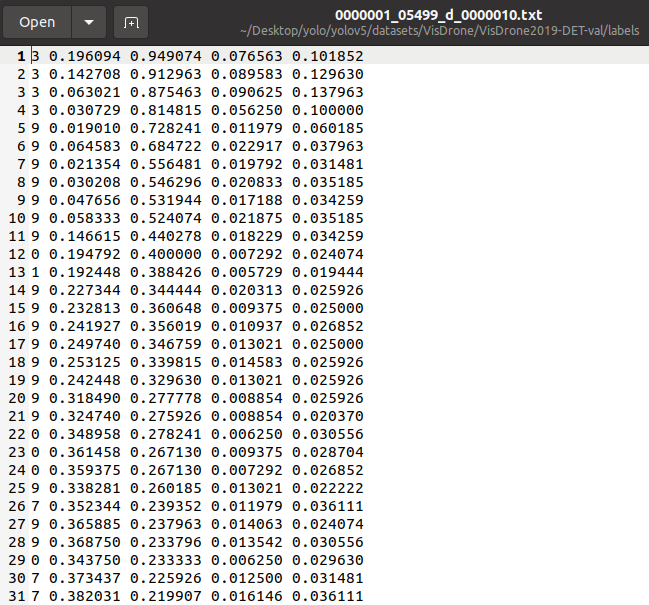

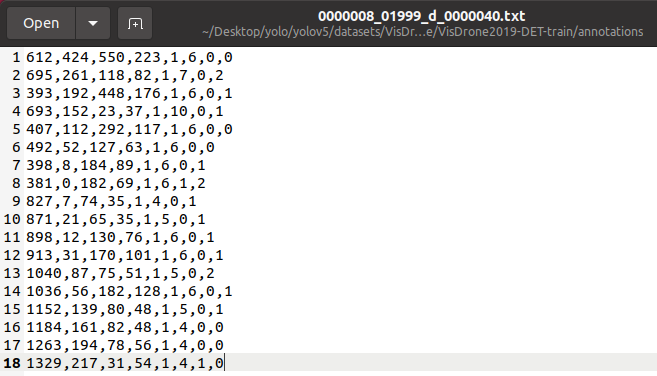

# 2. Validate
Validate a model's accuracy on [COCO](https://cocodataset.org/#home) val or test-dev datasets. Models are downloaded automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases). To show results by class use the `--verbose` flag. Note that `pycocotools` metrics may be ~1% better than the equivalent repo metrics, as is visible below, due to slight differences in mAP computation.

## COCO val
Download [COCO val 2017](https://github.com/ultralytics/yolov5/blob/74b34872fdf41941cddcf243951cdb090fbac17b/data/coco.yaml#L14) dataset (1GB - 5000 images), and test model accuracy.

In [9]:
# Download COCO val
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../datasets && rm tmp.zip

  0%|          | 0.00/780M [00:00<?, ?B/s]

In [ ]:
# Run YOLOv5x on COCO val
!python val.py --weights yolov5x.pt --data coco.yaml --img 640 --iou 0.65 --half

val: data=/content/yolov5/data/coco.yaml, weights=['yolov5x.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v6.0-48-g84a8099 torch 1.10.0+cu102 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

100% 166M/166M [00:03<00:00, 54.1MB/s]

Fusing layers... 
Model Summary: 444 layers, 86705005 parameters, 0 gradients
val: Scanning '../datasets/coco/val2017' images and labels...4952 found, 48 missing, 0 empty, 0 corrupted: 100% 5000/5000 [00:01<00:00, 2636.64it/s]
val: New cache created: ../datasets/coco/val2017.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 157/157 [01:12<00:00,  2.17it/s]
                 all       5000      36335      0.729       0.63      0.683      0.496
Speed: 0.1ms pre-process, 4.9ms inference, 1.9ms NMS per image a

## COCO test
Download [COCO test2017](https://github.com/ultralytics/yolov5/blob/74b34872fdf41941cddcf243951cdb090fbac17b/data/coco.yaml#L15) dataset (7GB - 40,000 images), to test model accuracy on test-dev set (**20,000 images, no labels**). Results are saved to a `*.json` file which should be **zipped** and submitted to the evaluation server at https://competitions.codalab.org/competitions/20794.

In [ ]:
# Download COCO test-dev2017
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017labels.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../datasets && rm tmp.zip
!f="test2017.zip" && curl http://images.cocodataset.org/zips/$f -o $f && unzip -q $f -d ../datasets/coco/images

In [ ]:
# Run YOLOv5x on COCO test
!python val.py --weights yolov5x.pt --data coco.yaml --img 640 --iou 0.65 --half --task test

# 3. Train

<p align=""><a href="https://roboflow.com/?ref=ultralytics"><img width="1000" src="https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/615627e5824c9c6195abfda9_computer-vision-cycle.png"/></a></p>
Close the active learning loop by sampling images from your inference conditions with the `roboflow` pip package
<br><br>

Train a YOLOv5s model on the [COCO128](https://www.kaggle.com/ultralytics/coco128) dataset with `--data coco128.yaml`, starting from pretrained `--weights yolov5s.pt`, or from randomly initialized `--weights '' --cfg yolov5s.yaml`.

- **Pretrained [Models](https://github.com/ultralytics/yolov5/tree/master/models)** are downloaded
automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases)
- **[Datasets](https://github.com/ultralytics/yolov5/tree/master/data)** available for autodownload include: [COCO](https://github.com/ultralytics/yolov5/blob/master/data/coco.yaml), [COCO128](https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml), [VOC](https://github.com/ultralytics/yolov5/blob/master/data/VOC.yaml), [Argoverse](https://github.com/ultralytics/yolov5/blob/master/data/Argoverse.yaml), [VisDrone](https://github.com/ultralytics/yolov5/blob/master/data/VisDrone.yaml), [GlobalWheat](https://github.com/ultralytics/yolov5/blob/master/data/GlobalWheat2020.yaml), [xView](https://github.com/ultralytics/yolov5/blob/master/data/xView.yaml), [Objects365](https://github.com/ultralytics/yolov5/blob/master/data/Objects365.yaml), [SKU-110K](https://github.com/ultralytics/yolov5/blob/master/data/SKU-110K.yaml).
- **Training Results** are saved to `runs/train/` with incrementing run directories, i.e. `runs/train/exp2`, `runs/train/exp3` etc.
<br><br>

## Train on Custom Data with Roboflow 🌟 NEW

[Roboflow](https://roboflow.com/?ref=ultralytics) enables you to easily **organize, label, and prepare** a high quality dataset with your own custom data. Roboflow also makes it easy to establish an active learning pipeline, collaborate with your team on dataset improvement, and integrate directly into your model building workflow with the `roboflow` pip package.

- Custom Training Example: [https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/](https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/?ref=ultralytics)
- Custom Training Notebook: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/yolov5-custom-training-tutorial/blob/main/yolov5-custom-training.ipynb)
<br>

<p align=""><a href="https://roboflow.com/?ref=ultralytics"><img width="480" src="https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/6152a275ad4b4ac20cd2e21a_roboflow-annotate.gif"/></a></p>Label images lightning fast (including with model-assisted labeling)

In [22]:
# Tensorboard  (optional)
%load_ext tensorboard
%tensorboard --logdir runs/train

## Image View for annotations/labels
#https://medium.com/analytics-vidhya/how-to-use-python-to-build-an-image-display-app-in-jupyter-notebook-337c4fd3775f


In [10]:
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import *
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
import string

/tmp/ipykernel_309271/2807519989.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [11]:
# read in dataframe
img_df = pd.DataFrame([['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot1.png','VisDrone_annot'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot2.png','VisDrone_annot'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot3.png','VisDrone_annot'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot4.png','VisDrone_annot'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot1.png','VisDrone_label'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot2.png','VisDrone_label'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot3.png','VisDrone_label'], \
                       ['/home/mgjeong/Desktop/yolo/yolov5/data/etc/vislabel4.png','VisDrone_label']], columns=['image_url', 'category'])#pd.read_csv('~/downloads/sports.csv')
img_df.head()

,image_url,category
0,/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot1.png,VisDrone_annot
1,/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot2.png,VisDrone_annot
2,/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot3.png,VisDrone_annot
3,/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot4.png,VisDrone_annot
4,/home/mgjeong/Desktop/yolo/yolov5/data/etc/visannot1.png,VisDrone_label


In [19]:
# read in dataframe
img_df = pd.DataFrame([['/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/images/train/9999945_00000_d_0000134.jpg','image'], \
                       ['/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/images/train/9999972_00000_d_0000024.jpg','image'], \
                       ['/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/labels/train/9999945_00000_d_0000134.txt','label'], \
                       ['/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/labels/train/9999972_00000_d_0000024.txt','label']], columns=['image_url', 'category'])#pd.read_csv('~/downloads/sports.csv')
img_df.head()

,image_url,category
0,/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/images/train/9999945_00000_d_0000134.jpg,image
1,/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/images/train/9999972_00000_d_0000024.jpg,image
2,/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/labels/train/9999945_00000_d_0000134.txt,label
3,/home/mgjeong/Desktop/yolo/datasets/VisDrone_Reduction/labels/train/9999972_00000_d_0000024.txt,label


In [20]:
image_grid = img_df[img_df['category'] == 'image']

In [21]:
def image_viewer(grid_length, grid_width, category):
    tmp_df = img_df[img_df['category'] == category]  # filter by sport input
    image_grid = tmp_df['image_url']
    image_grid_size = grid_length + grid_width
    image_grid = image_grid.iloc[0:image_grid_size] # size of grid 
    image_grid = image_grid.values #as_matrix() #turn into matrix for reshaping
    image_grid = image_grid.reshape(grid_length, grid_width) 
    image_grid = pd.DataFrame(image_grid)
    tmp = string.ascii_lowercase[:len(image_grid.columns)]
    image_grid.columns = list(tmp)
    image_grid_html = HTML(image_grid.to_html(escape=False ,formatters=dict(a=path_to_image_html, \
                                                        b=path_to_image_html)))
    display(image_grid_html)
    show_im()

In [22]:
def show_im():
    CSS = """
    .output {
        flex-direction: row;
    }
    """
    HTML('<style>{}</style>'.format(CSS))

In [30]:
![title]('9999945_00000_d_0000134.jpg')

/bin/bash: -c: 줄 0: 예기치 않은 토큰 ''9999945_00000_d_0000134.jpg'' 근처에서 문법 오류
/bin/bash: -c: 줄 0: `[title]('9999945_00000_d_0000134.jpg')'


In [28]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''
    rpath = '<img src="'+ path + '" style=max-height:124px;"/>'
    print(rpath)
    return rpath

In [29]:
PATH = "./data/etc/"
Image(filename = PATH+"visannot1.png", width=100, height=100)

Image(value=b'', height='100', width='100')

In [26]:
img_list = ['image', 'VisDrone_label']  # list of sports
#define widgets
display_widget = widgets.Dropdown(options=img_list)
#create tabs
tab_nest = widgets.Tab()
tab_nest.set_title(0, 'Annotation Images')

#interact function in isolation
f1 = interactive(image_viewer, grid_length=2, grid_width=2, category=display_widget);
tab_nest.children = [VBox(children = f1.children)]
display(tab_nest)


In [80]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --cache

Traceback (most recent call last):
  File "train.py", line 41, in <module>
    import val  # for end-of-epoch mAP
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/val.py", line 38, in <module>
    from models.common import DetectMultiBackend
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/models/common.py", line 24, in <module>
    from utils.datasets import exif_transpose, letterbox
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/utils/datasets.py", line 29, in <module>
    from utils.augmentations import Albumentations, augment_hsv, copy_paste, letterbox, mixup, random_perspective
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/utils/augmentations.py", line 12, in <module>
    from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/utils/general.py", line 36, in <module>
    from utils.metrics import box_iou, fitness
  File "/home/mgjeong/Desktop/yolo/yolov5/yolov5/utils/metrics.py", line 10, in <mo